In [ ]:
from numba import cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import numpy as np
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.pyplot as plt
import cv2

(1440, 2560, 3)


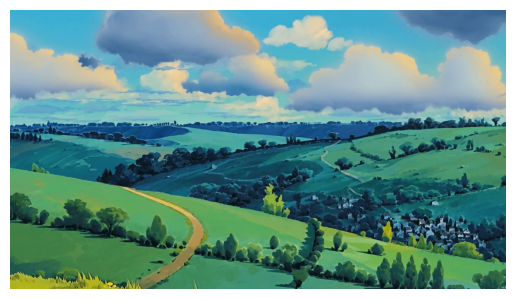

In [26]:
# load image from file(matplotlib's imread)
with cbook.get_sample_data('/content/sample.jpg') as image_file:
  img = plt.imread(image_file)

print(img.shape)
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

plt.show()

In [27]:
# Flatten image to 1D array of RGB
h, w, c = img.shape
total_pixel = h * w
flat_img = img.reshape(-1, 3).astype(np.float32)

print(flat_img)

[[ 66. 179. 209.]
 [ 65. 178. 210.]
 [ 60. 174. 208.]
 ...
 [ 48. 107.  79.]
 [ 45. 101.  72.]
 [ 39.  92.  64.]]


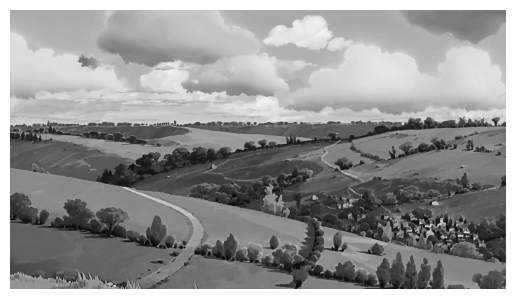

In [28]:
# Implement grayscale using CPU (for range)
gray_arr = np.zeros(total_pixel, dtype=np.float32)

for i in range(total_pixel):
  r, g, b = flat_img[i]
  gray_arr[i] = (r + g + b) / 3

gray_img = gray_arr.reshape(h, w)

fig, ax1 = plt.subplots()
ax1.imshow(gray_img, cmap="gray")
ax1.axis("off")

plt.show()

In [29]:
# Implement grayscale using GPU
!nvidia-smi

Sat Oct  4 16:42:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P0             31W /   70W |     168MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

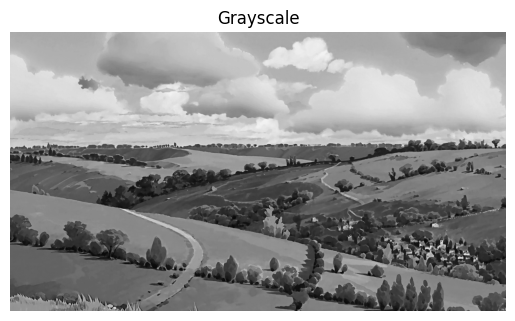

In [35]:
import cupy as cp
import numpy as np

# Copy data to GPU
flat_img_gpu = cp.asarray(flat_img, dtype=cp.uint8)
gray_gpu = cp.empty(total_pixel, dtype=cp.uint8)

# CUDA kernel viết bằng CuPy
kernel = cp.RawKernel(r'''
extern "C" __global__
void rgb2gray(const unsigned char* img, unsigned char* gray, int total_pixel) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < total_pixel) {
        int idx = i * 3;
        unsigned char r = img[idx];
        unsigned char g = img[idx + 1];
        unsigned char b = img[idx + 2];
        gray[i] = (r + g + b) / 3;
    }
}
''', 'rgb2gray')

# Configure GPU
threadsperblock = 256
blockspergrid = (total_pixel + threadsperblock - 1) // threadsperblock

# Kernel
kernel((blockspergrid,), (threadsperblock,), (flat_img_gpu, gray_gpu, total_pixel))

# Result
gray_result = cp.asnumpy(gray_gpu).reshape(h, w)

# Display

plt.imshow(gray_result, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.show()

Block size 32: 0.407424 ms
Block size 64: 0.183200 ms
Block size 128: 0.147456 ms
Block size 256: 0.143360 ms
Block size 512: 0.166528 ms
Block size 1024: 0.441088 ms


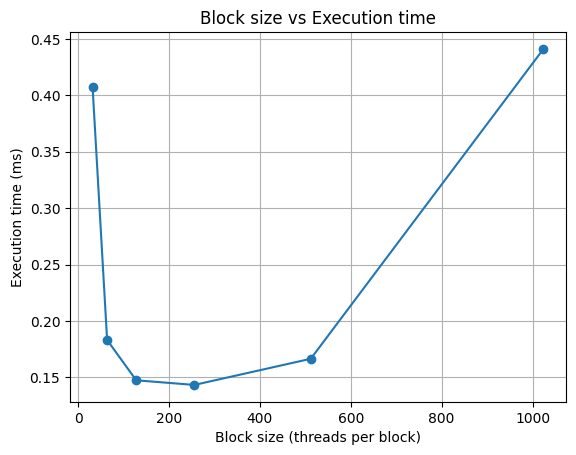

In [36]:
block_sizes = [32, 64, 128, 256, 512, 1024]
times = []

for threadsperblock in block_sizes:
    blockspergrid = (total_pixel + threadsperblock - 1) // threadsperblock

    # Warm-up run
    kernel((blockspergrid,), (threadsperblock,), (flat_img_gpu, gray_gpu, total_pixel))
    cp.cuda.Stream.null.synchronize()

    # Timing with CUDA events
    start = cp.cuda.Event()
    end = cp.cuda.Event()

    # Record kernel
    start.record()
    kernel((blockspergrid,), (threadsperblock,), (flat_img_gpu, gray_gpu, total_pixel))
    end.record()

    end.synchronize()
    elapsed = cp.cuda.get_elapsed_time(start, end)  # in ms
    times.append(elapsed)
    print(f"Block size {threadsperblock}: {elapsed:.6f} ms")

# Plot results
plt.plot(block_sizes, times, marker='o')
plt.xlabel("Block size (threads per block)")
plt.ylabel("Execution time (ms)")
plt.title("Block size vs Execution time")
plt.grid(True)
plt.show()

In [ ]:
!pip install numba==0.57.1 --only-binary :all:


ERROR: Could not find a version that satisfies the requirement numba==0.57.1 (from versions: 0.59.0rc1, 0.59.0, 0.59.1, 0.60.0rc1, 0.60.0, 0.61.0rc1, 0.61.0rc2, 0.61.0, 0.61.1rc1, 0.61.2, 0.62.0rc2, 0.62.0, 0.62.1)
ERROR: No matching distribution found for numba==0.57.1


In [ ]:
# Allocate output grayscale image
gray_img = np.zeros(total_pixel, dtype=np.uint8)

# Copy data to GPU
d_img = cuda.to_device(flat_img)
d_gray = cuda.to_device(gray_img)

# CUDA kernel (1 thread = 1 pixel)
@cuda.jit
def rgb2gray_flat(img, gray, total_pixel):
    i = cuda.grid(1)  # 1D thread index
    if i < total_pixel:
        r = img[i, 0]
        g = img[i, 1]
        b = img[i, 2]
        gray[i] = (r + g + b) / 3

# Configure GPU
threadsperblock = 256
blockspergrid = (total_pixel + threadsperblock - 1) // threadsperblock

# Launch kernel
rgb2gray_flat[blockspergrid, threadsperblock](d_img, d_gray, total_pixel)

# Copy back
gray_result = d_gray.copy_to_host().reshape(h, w)

# Show result
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gray_result, cmap="gray")
plt.title("Grayscale (Numba CUDA Flat)")
plt.axis("off")

plt.show()

ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION


LinkerError: [222] Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION
ptxas application ptx input, line 9; fatal   : Unsupported .version 8.5; current version is '8.4'